# Прогнозирование оттока клиентов банка

## Описание проекта. Цели и задачи. Описание данных

**Задача:** Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

На основе исторических данных о поведении клиентов и расторжении договоров с банком нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

**Целевые метрики:** F1-мера (главная метрика) и AUC-ROC

**Описание данных:**
* Признаки

  * `RowNumber` — индекс строки в данных
  
  * `CustomerId` — уникальный идентификатор клиента
  
  * `Surname` — фамилия
  
  * `CreditScore` — кредитный рейтинг
  
  * `Geography` — страна проживания
  
  * `Gender` — пол
  
  * `Age` — возраст
  
  * `Tenure` — сколько лет человек является клиентом банка
  
  * `Balance` — баланс на счёте
  
  * `NumOfProducts` — количество продуктов банка, используемых клиентом
  
  * `HasCrCard` — наличие кредитной карты
  
  * `IsActiveMember` — активность клиента
  
  * `EstimatedSalary` — предполагаемая зарплата

* Целевой признак

  * `Exited` — факт ухода клиента

In [75]:
!pip install imblearn

  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

## Загрузка и предобработка данных

In [2]:
data = pd.read_csv('churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
# Проверка
len(data['CustomerId'].unique())

10000

Столбцы `RowNumber` и `Surname` не несут большой смысловой нагрузки, так как первый - номер строки, а второй - фамилия клиента, в то же время у каждого клиента есть свой уникальный ID, который можно использовать для анализа. Удалим их

In [5]:
var_non_informative = ['RowNumber', 'CustomerId', 'Surname']
var_numeric = ['credit_score', 'age', 'tenure', 'balance', 
               'num_of_products', 'has_cr_card', 'is_active_member', 
               'estimated_salary']
var_categorical = ['geography', 'gender']
data = data.drop(var_non_informative, axis=1)

Разберемся теперь с названиями столбцов. Для удобства переведем их все в нижний регистр

In [6]:
data = data.rename(
    columns={
        'CreditScore' : 'credit_score',
        'Geography' : 'geography',
        'Gender' : 'gender',
        'Age' : 'age',
        'Tenure' : 'tenure',
        'Balance' : 'balance',
        'NumOfProducts' : 'num_of_products',
        'HasCrCard' : 'has_cr_card',
        'IsActiveMember' : 'is_active_member',
        'EstimatedSalary' : 'estimated_salary',
        'Exited' : 'exited'
    }
)

В столбце `tenure` имеется 909 пропусков. Это 9% от общего числа данных... Заменим пропуски медианным значением. (Важные основания, чтобы не удалять данные, содержащие пропуски: таблица не заполняется клиентами, она заполняется автоматически, информационной системой банка, поэтому, если бы даже клиент недавно пришёл, число было бы маленьким, но оно было бы)

In [7]:
data['tenure'] = data['tenure'].fillna(data['tenure'].median())

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


In [9]:
data.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


## Кодирование категориальных признаков

Теперь займемся подготовкой данных к работе с моделями машинного обучения. Для начала произведем кодирование категориальных признаков, коих у нас два: страна и пол (еще есть колонки, говорящие о наличии кредитной карты и об активности клиента, но они уже, можно сказать, закодированы).

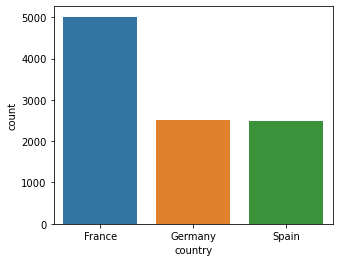

In [10]:
geography_pivot = data.pivot_table(index='geography', values='is_active_member', aggfunc='count')

fig, ax = plt.subplots(figsize = (5, 4))
graph = sns.barplot(x=geography_pivot.index, y=geography_pivot['is_active_member'], ax=ax)
graph.set_ylabel('count', fontsize=10)
graph.set_xlabel('country', fontsize=10)
plt.show()

Больше всего информации о клиентах из Франции. Примерно одинаково количество информации о клиентах из Германии и Испании

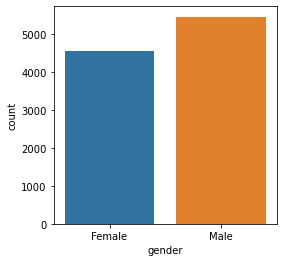

In [11]:
gender_pivot = data.pivot_table(index='gender', values='is_active_member', aggfunc='count')

fig, ax = plt.subplots(figsize = (4, 4))
graph = sns.barplot(x=gender_pivot.index, y=gender_pivot['is_active_member'], ax=ax)
graph.set_ylabel('count', fontsize=10)
graph.set_xlabel('gender', fontsize=10)
plt.show()

Мужчины чаще становились клиентами в банке. В целом это довольно логично.

Разбиваем данные на 3 выборки: тренировочную, валидационную и тестовую. Соотношение 3:1:1.

In [12]:
X, y = data.drop(['exited'], axis=1), data['exited']

X_train, X_prom, y_train, y_prom = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_prom, y_prom, test_size=0.5, stratify=y_prom, random_state=42)

In [13]:
X_train.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
6851,527,Germany,Female,39,9.0,96748.89,2,1,0,94711.43
7026,677,France,Female,27,5.0,0.00,2,0,1,114685.92
5705,628,Germany,Male,40,5.0,181768.32,2,1,1,129107.97
9058,470,Spain,Female,48,5.0,140576.11,1,1,1,116971.05
9415,768,Germany,Female,43,2.0,129264.05,2,0,0,19150.14


In [14]:
y_train.head()

6851    0
7026    0
5705    0
9058    0
9415    0
Name: exited, dtype: int64

In [15]:
X_valid.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
8583,591,France,Female,38,2.0,142289.28,1,0,1,119638.85
1924,667,France,Male,44,8.0,122277.87,1,1,1,91810.71
3195,697,Germany,Male,29,0.0,172693.54,1,0,0,141798.98
5263,809,Germany,Male,41,1.0,79706.25,2,1,0,165675.01
1484,850,Spain,Female,29,1.0,0.00,2,1,1,197996.65


In [16]:
y_valid.head()

8583    0
1924    0
3195    0
5263    0
1484    0
Name: exited, dtype: int64

In [17]:
X_test.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
9167,607,France,Male,26,1.0,0.00,1,1,0,29818.20
9387,524,France,Male,32,1.0,144875.71,1,0,0,187740.04
6859,733,France,Female,38,3.0,157658.36,1,0,0,19658.43
3500,850,France,Female,32,5.0,106290.64,1,1,0,121982.73
6233,850,France,Male,34,2.0,72079.71,1,1,1,115767.93


In [18]:
y_test.head()

9167    0
9387    0
6859    0
3500    0
6233    0
Name: exited, dtype: int64

In [19]:
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')  # удаляем первый столбец чтобы не попасть в дамми-ловушку

features_train_ohe = pd.DataFrame(
    encoder.fit_transform(X_train[var_categorical]).toarray(),
    columns=encoder.get_feature_names_out()
)

features_valid_ohe = pd.DataFrame(
    encoder.transform(X_valid[var_categorical]).toarray(),
    columns=encoder.get_feature_names_out()
)

features_test_ohe = pd.DataFrame(
    encoder.transform(X_test[var_categorical]).toarray(),
    columns=encoder.get_feature_names_out()
)

In [20]:
features_train_ohe.head()

,geography_Germany,geography_Spain,gender_Male
0,1.0,0.0,0.0
1,0.0,0.0,0.0
2,1.0,0.0,1.0
3,0.0,1.0,0.0
4,1.0,0.0,0.0


In [21]:
scaler = StandardScaler()

features_train_numeric = pd.DataFrame(
    scaler.fit_transform(X_train[var_numeric]),
    columns=var_numeric
)
features_valid_numeric = pd.DataFrame(
    scaler.transform(X_valid[var_numeric]),
    columns=var_numeric
)
features_test_numeric = pd.DataFrame(
    scaler.transform(X_test[var_numeric]),
    columns=var_numeric
)

In [22]:
features_train_enc = features_train_ohe.join(features_train_numeric)
features_valid_enc = features_valid_ohe.join(features_valid_numeric)
features_test_enc = features_test_ohe.join(features_test_numeric)

features_train_enc.shape, features_valid_enc.shape, features_test_enc.shape

((6000, 11), (2000, 11), (2000, 11))

In [23]:
y_train.reset_index(inplace=True, drop=True)
y_valid.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

## Исследование баланса классов

<AxesSubplot:>

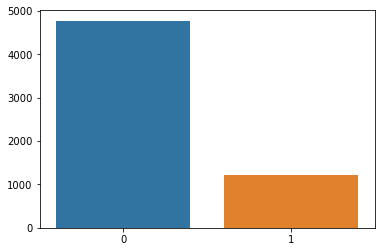

In [24]:
sns.barplot(x=[0, 1], y=[list(y_train).count(0), list(y_train).count(1)]);

Видно, что данные явно не сбалансированы: клиенты все-таки чаще остаются, чем уходят.

## Обучение моделей без учета дисбаланса классов

#### Логистическая регрессия

In [25]:
log_reg_disbalanced = LogisticRegression(solver='liblinear', random_state=42)
log_reg_disbalanced.fit(features_train_enc, y_train)

train_pred = log_reg_disbalanced.predict(features_train_enc)
valid_pred = log_reg_disbalanced.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.297480024585126
F1-мера на валидационной выборке: 0.32792792792792796

AUC-ROC на тренировочной выборке: 0.5819606571033769
AUC-ROC на валидационной выборке: 0.5939316681446448


Сравним теперь F1-меру нашей модели с F1-мерой константной модели. В качестве константной модели возьмем модель, которая предсказывает только нули или только 1.

In [26]:
print('Только нули:', f1_score(y_valid, [0] * y_valid.shape[0]))
print('Только единицы:', f1_score(y_valid, [1] * y_valid.shape[0]))

Только нули: 0.0
Только единицы: 0.3388704318936877


F1-мера нашей модели значительно хуже F1-меры константной модели... Значит, наша модель не прошла проверку на адекватность.

#### Случайный лес

Будем перебирать различные комбинации количества деревьев в лесу и глубины каждого дерева, чтобы выявить наиболее оптимальные параметры.

In [27]:
best_score = 0
best_number = 0
best_depth = 0
for number in range(10, 151, 10):
    for depth in range(1, 12):
        rf = RandomForestClassifier(n_estimators=number, max_depth=depth, random_state=42)
        rf.fit(features_train_enc, y_train)
        f1 = f1_score(y_valid, rf.predict(features_valid_enc))
        if f1 > best_score:
            best_score = f1
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print('Метрика F1:', best_score)

Оптимальная глубина: 11
Оптимальное количество деревьев: 70
Метрика F1: 0.6266866566716642


In [28]:
rf_disbalanced = RandomForestClassifier(n_estimators=70, max_depth=11, random_state=42)
rf_disbalanced.fit(features_train_enc, y_train)

train_pred = rf_disbalanced.predict(features_train_enc)
valid_pred = rf_disbalanced.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.7732415150024595
F1-мера на валидационной выборке: 0.6266866566716642

AUC-ROC на тренировочной выборке: 0.8189877705988783
AUC-ROC на валидационной выборке: 0.7404239333924525


Что точно можно сказать, так это то, что данная модель сильно превосходит константную и по F1, и по AUC-ROC. Однако, судя по сильному разрыву ее результатов на тренировочной и валидационной выборках, она переобучена.

#### Решающее дерево

In [29]:
best_score = 0
best_depth = 0
for depth in range(1, 12):
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(features_train_enc, y_train)
    f1 = f1_score(y_valid, tree.predict(features_valid_enc))
    if f1 > best_score:
        best_score = f1
        best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Метрика F1:', best_score)

Оптимальная глубина: 8
Метрика F1: 0.5906432748538012


In [30]:
tree_disbalanced = DecisionTreeClassifier(max_depth=8, random_state=42)
tree_disbalanced.fit(features_train_enc, y_train)

train_pred = tree_disbalanced.predict(features_train_enc)
valid_pred = tree_disbalanced.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.6521953626048347
F1-мера на валидационной выборке: 0.5906432748538012

AUC-ROC на тренировочной выборке: 0.7553891985840723
AUC-ROC на валидационной выборке: 0.7243078135776925


"Деревянные" модели показали более высокие результаты, чем логистическая регрессия. Правда, они несколько переобучились. Попробуем учесть дисбаланс классов

## Учет дисбаланса классов

В ходе выполнения проекта будут испробованы три техники: upsampling, downsampling и выставление параметра `class_weight='balanced'`. Однако стоит отметить, что, согласно материалам статьи, техника downsampling часто дает менее хорошие результаты, чем upsampling, так как мы вынуждены отказываться от части данных. Также при работе с логистической регрессией можно попробовать поизменять порог классификации.

### Balanced class weight

#### Логистическая регрессия

In [31]:
best_score = 0
best_С = 0
for c in np.arange(0.1, 2.0, 0.1):
    log_reg = LogisticRegression(solver='liblinear', class_weight='balanced', C=c, random_state=42)
    log_reg.fit(features_train_enc, y_train)
    f1 = f1_score(y_valid, log_reg.predict(features_valid_enc))
    if f1 > best_score:
        best_score = f1
        best_C = c

print('Оптимальный параметр регуляризации:', best_C)
print('Метрика F1:', best_score)

Оптимальный параметр регуляризации: 0.2
Метрика F1: 0.5212947189097105


In [32]:
log_reg = LogisticRegression(solver='liblinear', class_weight='balanced', C=0.2, random_state=42)
log_reg.fit(features_train_enc, y_train)

train_pred = log_reg.predict(features_train_enc)
valid_pred = log_reg.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.4870526622054117
F1-мера на валидационной выборке: 0.5212947189097105

AUC-ROC на тренировочной выборке: 0.6982687632006763
AUC-ROC на валидационной выборке: 0.7305276381909548


В результате сбалансирования классов все метрики логистической регрессии существенно повысились. Также стоит отметить, что метрики на тренировочной выборке ниже метрик на валидационной, что говорит об отсутствии переобучения. Ну и последнее замечание: наша новая модель предсказывает гораздо лучше константной модели, а значит, ее можно считать адекватной

#### Решающее дерево

In [33]:
best_score = 0
best_depth = 0
for depth in range(1, 12):
    tree = DecisionTreeClassifier(max_depth=depth, class_weight='balanced', random_state=42)
    tree.fit(features_train_enc, y_train)
    f1 = f1_score(y_valid, tree.predict(features_valid_enc))
    if f1 > best_score:
        best_score = f1
        best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Метрика F1:', best_score)

Оптимальная глубина: 6
Метрика F1: 0.5754141238012207


In [34]:
tree = DecisionTreeClassifier(max_depth=6, class_weight='balanced', random_state=42)
tree.fit(features_train_enc, y_train)

train_pred = tree.predict(features_train_enc)
valid_pred = tree.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.5974576271186441
F1-мера на валидационной выборке: 0.5754141238012207

AUC-ROC на тренировочной выборке: 0.7892584602505073
AUC-ROC на валидационной выборке: 0.7759569908365356


F1-мера ниже требуемой в задании

#### Случайный лес

In [35]:
best_score = 0
best_number = 0
best_depth = 0
for number in range(10, 151, 10):
    for depth in range(1, 12):
        rf = RandomForestClassifier(n_estimators=number, max_depth=depth, class_weight='balanced', random_state=42)
        rf.fit(features_train_enc, y_train)
        f1 = f1_score(y_valid, rf.predict(features_valid_enc))
        if f1 > best_score:
            best_score = f1
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print('Метрика F1:', best_score)

Оптимальная глубина: 7
Оптимальное количество деревьев: 20
Метрика F1: 0.6348547717842323


In [36]:
rf = RandomForestClassifier(n_estimators=20, max_depth=7, class_weight='balanced', random_state=42)
rf.fit(features_train_enc, y_train)

train_pred = rf.predict(features_train_enc)
valid_pred = rf.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.6585973656105376
F1-мера на валидационной выборке: 0.6348547717842323

AUC-ROC на тренировочной выборке: 0.809202057438656
AUC-ROC на валидационной выборке: 0.7964824120603016


Видно, что метрики довольно высокие, причем практически одинаковые на тренировочной и валидационной выборках. Судя по всему, переобучения нет.

**Вывод:** При учете дисбалансса классов с помощью установки параметра `class_weight='balanced'` лучший результат показывает модель случайного леса с параметрами:

`RandomForestClassifier(
    n_estimators=20,
    max_depth=7,
    class_weight='balanced',
    random_state=42
)`

Техники upsampling и downsampling представлены двумя типами: реализация "вручную", то есть просто повторением объектов меньшего класса и удалением случайных элементов большего, соответственно, и с помощью методов `SMOTE` и `RandomUnderSampler` библиотеки `imblearn`

### Upsampling "руками"

In [37]:
# Разделение обучающей выборки на "положительные" и "отрицательные" объекты
features_zeros = features_train_enc[y_train == 0]
features_ones = features_train_enc[y_train == 1]
target_zeros = y_train[y_train == 0]
target_ones = y_train[y_train == 1]

# Собственно upsampling
X_upsampled = pd.concat([features_zeros] + [features_ones] * 4)
y_upsampled = pd.concat([target_zeros] + [target_ones] * 4)

# Перемешивание данных
X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=42)

#### Логистическая регрессия

In [38]:
best_score = 0
best_С = 0
for c in np.arange(0.1, 2.0, 0.1):
    log_reg = LogisticRegression(solver='liblinear', C=c, random_state=42)
    log_reg.fit(X_upsampled, y_upsampled)
    f1 = f1_score(y_valid, log_reg.predict(features_valid_enc))
    if f1 > best_score:
        best_score = f1
        best_C = c

print('Оптимальный параметр регуляризации:', best_C)
print('Метрика F1:', best_score)

Оптимальный параметр регуляризации: 0.1
Метрика F1: 0.5210084033613445


In [39]:
log_reg = LogisticRegression(solver='liblinear', C=0.1, random_state=42)
log_reg.fit(X_upsampled, y_upsampled)

train_pred = log_reg.predict(features_train_enc)
valid_pred = log_reg.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.48580441640378536
F1-мера на валидационной выборке: 0.5210084033613445

AUC-ROC на тренировочной выборке: 0.698174564407654
AUC-ROC на валидационной выборке: 0.7316607547541629


Логистическая регрессия показала примерно такой же результат, как в случае установки `class_weight='balanced'`.

#### Решающее дерево

In [40]:
best_score = 0
best_depth = 0
for depth in range(1, 12):
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_upsampled, y_upsampled)
    f1 = f1_score(y_valid, tree.predict(features_valid_enc))
    if f1 > best_score:
        best_score = f1
        best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Метрика F1:', best_score)

Оптимальная глубина: 6
Метрика F1: 0.5749128919860628


In [41]:
tree = DecisionTreeClassifier(max_depth=6, random_state=42)
tree.fit(X_upsampled, y_upsampled)

train_pred = tree.predict(features_train_enc)
valid_pred = tree.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.5974576271186441
F1-мера на валидационной выборке: 0.5749128919860628

AUC-ROC на тренировочной выборке: 0.7892584602505073
AUC-ROC на валидационной выборке: 0.7756429204847768


Здесь результат такой же, как при установке `class_weight='balanced'`

#### Случайный лес

In [42]:
# max_features принимает значение по умолчанию
best_score = 0
best_number = 0
best_depth = 0
for number in range(10, 151, 10):
    for depth in range(1, 12):
        rf = RandomForestClassifier(n_estimators=number, max_depth=depth, random_state=42)
        rf.fit(X_upsampled, y_upsampled)
        f1 = f1_score(y_valid, rf.predict(features_valid_enc))
        if f1 > best_score:
            best_score = f1
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print('Метрика F1:', best_score)

Оптимальная глубина: 10
Оптимальное количество деревьев: 130
Метрика F1: 0.6362672322375397


In [43]:
rf = RandomForestClassifier(n_estimators=130, max_depth=10, random_state=42)
rf.fit(X_upsampled, y_upsampled)

train_pred = rf.predict(features_train_enc)
valid_pred = rf.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.8042135851798038
F1-мера на валидационной выборке: 0.6362672322375397

AUC-ROC на тренировочной выборке: 0.9085759608790701
AUC-ROC на валидационной выборке: 0.7938405261602128


Модель явно переобучена. Попробуем снизить степень переобучения, экспериментируя с параметром `max_features`

In [44]:
# max_features=4
best_score = 0
best_number = 0
best_depth = 0
for number in range(10, 151, 10):
    for depth in range(1, 12):
        rf = RandomForestClassifier(n_estimators=number, max_depth=depth, max_features=4, random_state=42)
        rf.fit(X_upsampled, y_upsampled)
        f1 = f1_score(y_valid, rf.predict(features_valid_enc))
        if f1 > best_score:
            best_score = f1
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print('Метрика F1:', best_score)

Оптимальная глубина: 10
Оптимальное количество деревьев: 110
Метрика F1: 0.635593220338983


In [45]:
rf = RandomForestClassifier(n_estimators=110, max_depth=10, max_features=4, random_state=42)
rf.fit(X_upsampled, y_upsampled)

train_pred = rf.predict(features_train_enc)
valid_pred = rf.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.8099891422366993
F1-мера на валидационной выборке: 0.635593220338983

AUC-ROC на тренировочной выборке: 0.9136952371035002
AUC-ROC на валидационной выборке: 0.7935264558084539


In [46]:
# max_features=5
best_score = 0
best_number = 0
best_depth = 0
for number in range(10, 151, 10):
    for depth in range(1, 12):
        rf = RandomForestClassifier(n_estimators=number, max_depth=depth, max_features=5, random_state=42)
        rf.fit(X_upsampled, y_upsampled)
        f1 = f1_score(y_valid, rf.predict(features_valid_enc))
        if f1 > best_score:
            best_score = f1
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print('Метрика F1:', best_score)

Оптимальная глубина: 10
Оптимальное количество деревьев: 150
Метрика F1: 0.6293558606124603


In [47]:
rf = RandomForestClassifier(n_estimators=150, max_depth=10, max_features=5, random_state=42)
rf.fit(X_upsampled, y_upsampled)

train_pred = rf.predict(features_train_enc)
valid_pred = rf.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.8094555873925502
F1-мера на валидационной выборке: 0.6293558606124603

AUC-ROC на тренировочной выборке: 0.9163124221147253
AUC-ROC на валидационной выборке: 0.7895051236575032


In [48]:
# max_features=6
best_score = 0
best_number = 0
best_depth = 0
for number in range(10, 151, 10):
    for depth in range(1, 12):
        rf = RandomForestClassifier(n_estimators=number, max_depth=depth, max_features=6, random_state=42)
        rf.fit(X_upsampled, y_upsampled)
        f1 = f1_score(y_valid, rf.predict(features_valid_enc))
        if f1 > best_score:
            best_score = f1
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print('Метрика F1:', best_score)

Оптимальная глубина: 11
Оптимальное количество деревьев: 110
Метрика F1: 0.6295081967213115


In [49]:
rf = RandomForestClassifier(n_estimators=110, max_depth=11, max_features=6, random_state=42)
rf.fit(X_upsampled, y_upsampled)

train_pred = rf.predict(features_train_enc)
valid_pred = rf.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.8747236551215918
F1-мера на валидационной выборке: 0.6295081967213115

AUC-ROC на тренировочной выборке: 0.9537620942686713
AUC-ROC на валидационной выборке: 0.7841597694354124


In [50]:
# max_features=7
best_score = 0
best_number = 0
best_depth = 0
for number in range(10, 151, 10):
    for depth in range(1, 12):
        rf = RandomForestClassifier(n_estimators=number, max_depth=depth, max_features=7, random_state=42)
        rf.fit(X_upsampled, y_upsampled)
        f1 = f1_score(y_valid, rf.predict(features_valid_enc))
        if f1 > best_score:
            best_score = f1
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print('Метрика F1:', best_score)

Оптимальная глубина: 11
Оптимальное количество деревьев: 80
Метрика F1: 0.6376496191512514


In [51]:
rf = RandomForestClassifier(n_estimators=80, max_depth=11, max_features=7, random_state=42)
rf.fit(X_upsampled, y_upsampled)

train_pred = rf.predict(features_train_enc)
valid_pred = rf.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.8765294771968855
F1-мера на валидационной выборке: 0.6376496191512514

AUC-ROC на тренировочной выборке: 0.9529720233010135
AUC-ROC на валидационной выборке: 0.7906012907675634


Оптимальное значение параметра `max_features` - это значение по умолчанию. В этом случае переобучение самое низкое. Попробуем установить `min_samples_leaf=2`

In [52]:
rf = RandomForestClassifier(
    n_estimators=130,
    max_depth=10,
    min_samples_leaf=2,
    random_state=42
)
rf.fit(X_upsampled, y_upsampled)

train_pred = rf.predict(features_train_enc)
valid_pred = rf.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.7924936845904006
F1-мера на валидационной выборке: 0.6381647549530761

AUC-ROC на тренировочной выборке: 0.9020680231749583
AUC-ROC на валидационной выборке: 0.7980527638190956


**Вывод:** При учете дисбалансса классов с помощью техники upsampling "руками" лучший результат показывает модель случайного леса с параметрами:

`RandomForestClassifier(
    n_estimators=130,
    max_depth=10,
    min_samples_leaf=2,
    random_state=42
)`

Однако использование параметра `class_weight='balanced'` дает существенно лучшие результаты. И, к сожалению, все модели, которые были проработаны в этом разделе, оказались переобученными...

### Downsampling "руками"

In [53]:
# Разделение обучающей выборки на "положительные" и "отрицательные" объекты
features_zeros = features_train_enc[y_train == 0]
features_ones = features_train_enc[y_train == 1]
target_zeros = y_train[y_train == 0]
target_ones = y_train[y_train == 1]

# Собственно downsampling
X_downsampled = pd.concat([features_zeros.sample(frac=0.25, random_state=42)] + [features_ones])
y_downsampled = pd.concat([target_zeros.sample(frac=0.25, random_state=42)] + [target_ones])

# Перемешивание данных
X_downsampled, y_downsampled = shuffle(X_downsampled, y_downsampled, random_state=42)

#### Логистическая регрессия

In [54]:
best_score = 0
best_С = 0
for c in np.arange(0.1, 2.0, 0.1):
    log_reg = LogisticRegression(solver='liblinear', C=c, random_state=42)
    log_reg.fit(X_downsampled, y_downsampled)
    f1 = f1_score(y_valid, log_reg.predict(features_valid_enc))
    if f1 > best_score:
        best_score = f1
        best_C = c

print('Оптимальный параметр регуляризации:', best_C)
print('Метрика F1:', best_score)

Оптимальный параметр регуляризации: 0.9
Метрика F1: 0.5234113712374583


In [55]:
log_reg = LogisticRegression(solver='liblinear', C=0.9, random_state=42)
log_reg.fit(X_downsampled, y_downsampled)

train_pred = log_reg.predict(features_train_enc)
valid_pred = log_reg.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.48943460879497425
F1-мера на валидационной выборке: 0.5234113712374583

AUC-ROC на тренировочной выборке: 0.7017429859578715
AUC-ROC на валидационной выборке: 0.7343950142871218


Результаты практически не отличаются от полученных ранее

#### Решающее дерево

In [56]:
best_score = 0
best_depth = 0
for depth in range(1, 12):
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_downsampled, y_downsampled)
    f1 = f1_score(y_valid, tree.predict(features_valid_enc))
    if f1 > best_score:
        best_score = f1
        best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Метрика F1:', best_score)

Оптимальная глубина: 6
Метрика F1: 0.5827937095282146


In [57]:
tree = DecisionTreeClassifier(max_depth=6, random_state=42)
tree.fit(X_downsampled, y_downsampled)

train_pred = tree.predict(features_train_enc)
valid_pred = tree.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.5939586645468998
F1-мера на валидационной выборке: 0.5827937095282146

AUC-ROC на тренировочной выборке: 0.7786652065282846
AUC-ROC на валидационной выборке: 0.7735922258350576


Решающие деревья еще на одну сотую приблизились к пороговому для данного проекта значению метрики F1.

#### Случайный лес

In [58]:
# max_features принимает значение по умолчанию
best_score = 0
best_number = 0
best_depth = 0
for number in range(10, 151, 10):
    for depth in range(1, 12):
        rf = RandomForestClassifier(n_estimators=number, max_depth=depth, random_state=42)
        rf.fit(X_downsampled, y_downsampled)
        f1 = f1_score(y_valid, rf.predict(features_valid_enc))
        if f1 > best_score:
            best_score = f1
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print('Метрика F1:', best_score)

Оптимальная глубина: 7
Оптимальное количество деревьев: 130
Метрика F1: 0.609942638623327


In [59]:
rf = RandomForestClassifier(n_estimators=130, max_depth=7, random_state=42)
rf.fit(X_downsampled, y_downsampled)

train_pred = rf.predict(features_train_enc)
valid_pred = rf.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.6364820846905537
F1-мера на валидационной выборке: 0.609942638623327

AUC-ROC на тренировочной выборке: 0.8086075774194188
AUC-ROC на валидационной выборке: 0.7907429303379643


Попробуем поработать с параметрами `max_features` и `min_samples_leaf`

In [60]:
# max_features=4
best_score = 0
best_number = 0
best_depth = 0
for number in range(10, 151, 10):
    for depth in range(1, 12):
        rf = RandomForestClassifier(n_estimators=number, max_depth=depth, max_features=4, random_state=42)
        rf.fit(X_downsampled, y_downsampled)
        f1 = f1_score(y_valid, rf.predict(features_valid_enc))
        if f1 > best_score:
            best_score = f1
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print('Метрика F1:', best_score)

Оптимальная глубина: 6
Оптимальное количество деревьев: 90
Метрика F1: 0.6148007590132828


In [61]:
rf = RandomForestClassifier(n_estimators=90, max_depth=6, max_features=4, random_state=42)
rf.fit(X_downsampled, y_downsampled)

train_pred = rf.predict(features_train_enc)
valid_pred = rf.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.6208484051298915
F1-мера на валидационной выборке: 0.6148007590132828

AUC-ROC на тренировочной выборке: 0.7946865372455177
AUC-ROC на валидационной выборке: 0.79592817026308


In [62]:
# max_features=5
best_score = 0
best_number = 0
best_depth = 0
for number in range(10, 151, 10):
    for depth in range(1, 12):
        rf = RandomForestClassifier(n_estimators=number, max_depth=depth, max_features=5, random_state=42)
        rf.fit(X_downsampled, y_downsampled)
        f1 = f1_score(y_valid, rf.predict(features_valid_enc))
        if f1 > best_score:
            best_score = f1
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print('Метрика F1:', best_score)

Оптимальная глубина: 5
Оптимальное количество деревьев: 20
Метрика F1: 0.6134852801519468


In [63]:
rf = RandomForestClassifier(n_estimators=20, max_depth=5, max_features=5, random_state=42)
rf.fit(X_downsampled, y_downsampled)

train_pred = rf.predict(features_train_enc)
valid_pred = rf.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.6011865524060647
F1-мера на валидационной выборке: 0.6134852801519468

AUC-ROC на тренировочной выборке: 0.778977090168455
AUC-ROC на валидационной выборке: 0.7947026800670016


In [64]:
# max_features=6
best_score = 0
best_number = 0
best_depth = 0
for number in range(10, 151, 10):
    for depth in range(1, 12):
        rf = RandomForestClassifier(n_estimators=number, max_depth=depth, max_features=6, random_state=42)
        rf.fit(X_downsampled, y_downsampled)
        f1 = f1_score(y_valid, rf.predict(features_valid_enc))
        if f1 > best_score:
            best_score = f1
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print('Метрика F1:', best_score)

Оптимальная глубина: 4
Оптимальное количество деревьев: 30
Метрика F1: 0.61003861003861


In [65]:
rf = RandomForestClassifier(n_estimators=30, max_depth=4, max_features=6, random_state=42)
rf.fit(X_downsampled, y_downsampled)

train_pred = rf.predict(features_train_enc)
valid_pred = rf.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.587094617184888
F1-мера на валидационной выборке: 0.61003861003861

AUC-ROC на тренировочной выборке: 0.7660072865335461
AUC-ROC на валидационной выборке: 0.7892649522120405


In [66]:
# max_features=7
best_score = 0
best_number = 0
best_depth = 0
for number in range(10, 151, 10):
    for depth in range(1, 12):
        rf = RandomForestClassifier(n_estimators=number, max_depth=depth, max_features=7, random_state=42)
        rf.fit(X_downsampled, y_downsampled)
        f1 = f1_score(y_valid, rf.predict(features_valid_enc))
        if f1 > best_score:
            best_score = f1
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print('Метрика F1:', best_score)

Оптимальная глубина: 4
Оптимальное количество деревьев: 40
Метрика F1: 0.6010928961748634


In [67]:
rf = RandomForestClassifier(n_estimators=40, max_depth=4, max_features=7, random_state=42)
rf.fit(X_downsampled, y_downsampled)

train_pred = rf.predict(features_train_enc)
valid_pred = rf.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.58801261829653
F1-мера на валидационной выборке: 0.6010928961748634

AUC-ROC на тренировочной выборке: 0.7750214259436493
AUC-ROC на валидационной выборке: 0.7913464380727167


Оптимальное значение параметра `max_features=4`. В этом случае модель и не переобучается, и показывает самые высокие для данной техники результаты. Как и раньше, попробуем установить `min_samples_leaf=2`

In [68]:
rf = RandomForestClassifier(
    n_estimators=90,
    max_depth=6,
    max_features=4,
    min_samples_leaf=2,
    random_state=42
)
rf.fit(X_downsampled, y_downsampled)

train_pred = rf.predict(features_train_enc)
valid_pred = rf.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.6220032840722497
F1-мера на валидационной выборке: 0.610586011342155

AUC-ROC на тренировочной выборке: 0.7958093868583435
AUC-ROC на валидационной выборке: 0.7931323283082077


**Вывод:** При учете дисбалансса классов с помощью техники downsampling "руками" лучший результат показывает модель случайного леса с параметрами:

`RandomForestClassifier(
    n_estimators=90,
    max_depth=6,
    max_features=4,
    random_state=42
)`

### Изменение порога классификации для логистической регрессии

In [69]:
log_reg = LogisticRegression(solver='liblinear', C=0.1, random_state=42)
log_reg.fit(features_train_enc, y_train)

probabilities_train = log_reg.predict_proba(features_train_enc)[:,1]
probabilities_valid = log_reg.predict_proba(features_valid_enc)[:,1]

for threshold in np.arange(0, 0.51, 0.02):
    predicted_valid = [1 if i >= threshold else 0 for i in probabilities_valid]
    f1 = f1_score(y_valid, predicted_valid)
    auc_roc = roc_auc_score(y_valid, predicted_valid)

    print("Порог = {:.2f} | F1-мера = {:.3f}, AUC-ROC = {:.3f}".format(
        threshold, f1, auc_roc))

Порог = 0.00 | F1-мера = 0.339, AUC-ROC = 0.500
Порог = 0.02 | F1-мера = 0.339, AUC-ROC = 0.501
Порог = 0.04 | F1-мера = 0.352, AUC-ROC = 0.527
Порог = 0.06 | F1-мера = 0.372, AUC-ROC = 0.569
Порог = 0.08 | F1-мера = 0.388, AUC-ROC = 0.597
Порог = 0.10 | F1-мера = 0.407, AUC-ROC = 0.626
Порог = 0.12 | F1-мера = 0.435, AUC-ROC = 0.663
Порог = 0.14 | F1-мера = 0.457, AUC-ROC = 0.688
Порог = 0.16 | F1-мера = 0.473, AUC-ROC = 0.700
Порог = 0.18 | F1-мера = 0.493, AUC-ROC = 0.715
Порог = 0.20 | F1-мера = 0.510, AUC-ROC = 0.725
Порог = 0.22 | F1-мера = 0.510, AUC-ROC = 0.717
Порог = 0.24 | F1-мера = 0.514, AUC-ROC = 0.714
Порог = 0.26 | F1-мера = 0.519, AUC-ROC = 0.711
Порог = 0.28 | F1-мера = 0.536, AUC-ROC = 0.718
Порог = 0.30 | F1-мера = 0.519, AUC-ROC = 0.701
Порог = 0.32 | F1-мера = 0.522, AUC-ROC = 0.700
Порог = 0.34 | F1-мера = 0.505, AUC-ROC = 0.686
Порог = 0.36 | F1-мера = 0.491, AUC-ROC = 0.675
Порог = 0.38 | F1-мера = 0.471, AUC-ROC = 0.663
Порог = 0.40 | F1-мера = 0.443, AUC-ROC 

Видно, что лучшие значения метрик достигаются при пороге, равном 0.28

In [70]:
train_pred = [1 if i >= 0.28 else 0 for i in probabilities_train]
valid_pred = [1 if i >= 0.28 else 0 for i in probabilities_valid]

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.4754158964879852
F1-мера на валидационной выборке: 0.5361050328227571

AUC-ROC на тренировочной выборке: 0.675190401451278
AUC-ROC на валидационной выборке: 0.7182727362301705


Как можно заметить, при применении этой техники результаты немного лучше, чем при применении других техник учета дисбаланса классов к модели логистической регрессии, однако такой результат все еще не является достаточно хорошим.

### Upsampling с помощью SMOTE

In [71]:
lst = ['geography_Germany', 'geography_Spain', 'gender_Male']
for col in lst:
    features_train_enc[col] = features_train_enc[col].astype('int')
    features_valid_enc[col] = features_valid_enc[col].astype('int')
    features_test_enc[col] = features_test_enc[col].astype('int')

Параметр k_neighbors подбирался вручную опытным путем. При этом я перебрал значения от 3 до 8 включительно. Оптимальный по метрикам и степени переобучения результат - 6

In [72]:
sm = SMOTE(k_neighbors=6, random_state=42)
X_smote, y_smote = sm.fit_resample(features_train_enc, y_train)

In [73]:
X_smote.head()

,geography_Germany,geography_Spain,gender_Male,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
0,1,0,0,-1.283897,0.008566,1.449637,0.330105,0.783996,0.640913,-1.033563,-0.084061
1,0,0,0,0.271537,-1.139895,-0.001572,-1.220584,0.783996,-1.560275,0.967527,0.264021
2,1,0,1,-0.236571,0.104271,-0.001572,1.692794,0.783996,0.640913,0.967527,0.515344
3,0,1,0,-1.874962,0.869911,-0.001572,1.032566,-0.919109,0.640913,0.967527,0.303842
4,1,0,0,1.215167,0.391386,-1.089979,0.851257,0.783996,-1.560275,-1.033563,-1.400817


In [74]:
y_smote.head()

0    0
1    0
2    0
3    0
4    0
Name: exited, dtype: int64

#### Логистическая регрессия

In [75]:
best_score = 0
best_С = 0
for c in np.arange(0.1, 2.0, 0.1):
    log_reg = LogisticRegression(solver='liblinear', C=c, random_state=42)
    log_reg.fit(X_smote, y_smote)
    f1 = f1_score(y_valid, log_reg.predict(features_valid_enc))
    if f1 > best_score:
        best_score = f1
        best_C = c

print('Оптимальный параметр регуляризации:', best_C)
print('Метрика F1:', best_score)

Оптимальный параметр регуляризации: 0.2
Метрика F1: 0.5104529616724739


In [76]:
log_reg = LogisticRegression(solver='liblinear', C=0.2, random_state=42)
log_reg.fit(X_smote, y_smote)

train_pred = log_reg.predict(features_train_enc)
valid_pred = log_reg.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.4793584793584794
F1-мера на валидационной выборке: 0.5104529616724739

AUC-ROC на тренировочной выборке: 0.6901796559380521
AUC-ROC на валидационной выборке: 0.7186791802147996


Логистическая регрессия, как всегда, показала невысокий результат

#### Решающее дерево

In [77]:
best_score = 0
best_depth = 0
for depth in range(1, 12):
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_smote, y_smote)
    f1 = f1_score(y_valid, tree.predict(features_valid_enc))
    if f1 > best_score:
        best_score = f1
        best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Метрика F1:', best_score)

Оптимальная глубина: 7
Метрика F1: 0.5859375000000001


In [78]:
tree = DecisionTreeClassifier(max_depth=7, random_state=42)
tree.fit(X_smote, y_smote)

train_pred = tree.predict(features_train_enc)
valid_pred = tree.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.5942173479561316
F1-мера на валидационной выборке: 0.5859375000000001

AUC-ROC на тренировочной выборке: 0.7723446387870209
AUC-ROC на валидационной выборке: 0.7684008276677505


Дерево уже лучше

#### Случайный лес

In [79]:
best_score = 0
best_number = 0
best_depth = 0
for number in range(10, 151, 10):
    for depth in range(1, 12):
        rf = RandomForestClassifier(n_estimators=number, max_depth=depth, random_state=42)
        rf.fit(X_smote, y_smote)
        f1 = f1_score(y_valid, rf.predict(features_valid_enc))
        if f1 > best_score:
            best_score = f1
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print('Метрика F1:', best_score)

Оптимальная глубина: 7
Оптимальное количество деревьев: 80
Метрика F1: 0.6031746031746031


In [80]:
rf = RandomForestClassifier(n_estimators=80, max_depth=7, random_state=42)
rf.fit(X_smote, y_smote)

train_pred = rf.predict(features_train_enc)
valid_pred = rf.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.6260445682451253
F1-мера на валидационной выборке: 0.6031746031746031

AUC-ROC на тренировочной выборке: 0.7892502392649342
AUC-ROC на валидационной выборке: 0.7795841954872401


**Вывод:** При учете дисбалансса классов с помощью техники upsampling с использованием `SMOTE(k_neighbors=6, random_state=42)` лучший результат показывает модель случайного леса с параметрами:

`RandomForestClassifier(
    n_estimators=80,
    max_depth=7,
    random_state=42
)`

### Downsampling с помощью RandomUnderSampler

In [81]:
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(features_train_enc, y_train)
X_rus.shape, y_rus.shape

((2444, 11), (2444,))

In [82]:
X_rus.head()

,geography_Germany,geography_Spain,gender_Male,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary
0,1,0,1,-1.594984,-1.427010,0.361230,0.570849,0.783996,0.640913,-1.033563,-0.761112
1,0,0,1,0.727798,0.199976,-1.089979,-1.220584,0.783996,0.640913,-1.033563,1.196919
2,1,0,0,-0.101767,-0.182844,0.724032,-0.211228,0.783996,-1.560275,0.967527,-1.054621
3,0,0,0,-1.346114,0.199976,-1.089979,-1.220584,0.783996,0.640913,0.967527,0.236200
4,0,1,1,0.250798,-0.278549,1.449637,0.481436,-0.919109,-1.560275,0.967527,-1.333827


In [83]:
y_rus.head()

0    0
1    0
2    0
3    0
4    0
Name: exited, dtype: int64

#### Логистическая регрессия

In [84]:
best_score = 0
best_С = 0
for c in np.arange(0.1, 2.0, 0.1):
    log_reg = LogisticRegression(solver='liblinear', C=c, random_state=42)
    log_reg.fit(X_rus, y_rus)
    f1 = f1_score(y_valid, log_reg.predict(features_valid_enc))
    if f1 > best_score:
        best_score = f1
        best_C = c

print('Оптимальный параметр регуляризации:', best_C)
print('Метрика F1:', best_score)

Оптимальный параметр регуляризации: 0.1
Метрика F1: 0.5184563758389261


In [85]:
log_reg = LogisticRegression(solver='liblinear', C=0.1, random_state=42)
log_reg.fit(X_rus, y_rus)

train_pred = log_reg.predict(features_train_enc)
valid_pred = log_reg.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.48729792147806006
F1-мера на валидационной выборке: 0.5184563758389261

AUC-ROC на тренировочной выборке: 0.6990399944097299
AUC-ROC на валидационной выборке: 0.7294930535028081


Логистическая регрессия вновь показала невысокий результат

#### Решающее дерево

In [86]:
best_score = 0
best_depth = 0
for depth in range(1, 12):
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_rus, y_rus)
    f1 = f1_score(y_valid, tree.predict(features_valid_enc))
    if f1 > best_score:
        best_score = f1
        best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Метрика F1:', best_score)

Оптимальная глубина: 6
Метрика F1: 0.5941499085923218


In [87]:
tree = DecisionTreeClassifier(max_depth=6, random_state=42)
tree.fit(X_rus, y_rus)

train_pred = tree.predict(features_train_enc)
valid_pred = tree.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.5942307692307692
F1-мера на валидационной выборке: 0.5941499085923218

AUC-ROC на тренировочной выборке: 0.7776846827281889
AUC-ROC на валидационной выборке: 0.7849049167405655


Дерево лучше, чем регрессия. Причем оно даже не переобучено, судя по всему. Но результаты близки к пороговым

#### Случайный лес

In [88]:
# max_features принимает значение по умолчанию
best_score = 0
best_number = 0
best_depth = 0
for number in range(10, 151, 10):
    for depth in range(1, 12):
        rf = RandomForestClassifier(n_estimators=number, max_depth=depth, random_state=42)
        rf.fit(X_rus, y_rus)
        f1 = f1_score(y_valid, rf.predict(features_valid_enc))
        if f1 > best_score:
            best_score = f1
            best_number = number
            best_depth = depth

print('Оптимальная глубина:', best_depth)
print('Оптимальное количество деревьев:', best_number)
print('Метрика F1:', best_score)

Оптимальная глубина: 6
Оптимальное количество деревьев: 90
Метрика F1: 0.6150907354345748


In [89]:
rf = RandomForestClassifier(n_estimators=90, max_depth=6, random_state=42)
rf.fit(X_rus, y_rus)

train_pred = rf.predict(features_train_enc)
valid_pred = rf.predict(features_valid_enc)

print('F1-мера на тренировочной выборке:', f1_score(y_train, train_pred))
print('F1-мера на валидационной выборке:', f1_score(y_valid, valid_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(y_train, train_pred))
print('AUC-ROC на валидационной выборке:', roc_auc_score(y_valid, valid_pred))

F1-мера на тренировочной выборке: 0.6211424819435325
F1-мера на валидационной выборке: 0.6150907354345748

AUC-ROC на тренировочной выборке: 0.7951909289645189
AUC-ROC на валидационной выборке: 0.7950475416297171


Случайный лес не переобучился, как и решающее дерево, но его результаты получше.

**Вывод:** При учете дисбалансса классов с помощью техники downsampling с использованием `RandomUnderSampler` лучший результат показывает модель случайного леса с параметрами:

`RandomForestClassifier(
    n_estimators=90,
    max_depth=6,
    random_state=42
)`

## Выбор нескольких лучших моделей и итоговое тестирование

Подведем предварительные итоги.

Модели, которые не учитывают дисбаланс классов, справляются с задачей хуже, чем модели, учитывающие этот момент. Хочется отметить, что "деревянные" модели показывают более высокие результаты, чем модели логистической регрессии, однако логистическая регрессия более устойчива к переобучению.

В ходе исследования были опробованы несколько техник учета дисбаланса классов: установка параметра `class_weight='balanced'`, upsampling, downsampling и изменение порога классификации у логистической регрессии. Техники upsampling и downsampling были реализованы двумя способами: вручную и с помощью библиотеки `imblearn`. В каждой из первых трех техник была выявлена своя лучшая модель, и именно эти модели мы возьмем для проведения итогового тестирования

In [90]:
features_train = pd.concat([features_train_enc, features_valid_enc]).reset_index(drop=True)
target_train = pd.concat([y_train, y_valid]).reset_index(drop=True)

#features_test_enc, y_test - тестовый набор данных

### Balanced class weight

In [91]:
rf = RandomForestClassifier(n_estimators=20, max_depth=7, class_weight='balanced', random_state=42)
rf.fit(features_train, target_train)

train_pred = rf.predict(features_train)
test_pred = rf.predict(features_test_enc)

print('F1-мера на тренировочной выборке:', f1_score(target_train, train_pred))
print('F1-мера на тестовой выборке:', f1_score(y_test, test_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(target_train, train_pred))
print('AUC-ROC на тестовой выборке:', roc_auc_score(y_test, test_pred))

F1-мера на тренировочной выборке: 0.6447916666666668
F1-мера на тестовой выборке: 0.5947643979057591

AUC-ROC на тренировочной выборке: 0.8034594677890033
AUC-ROC на тестовой выборке: 0.7660318253538594


### Upsampling "руками"

In [92]:
# Разделение обучающей выборки на "положительные" и "отрицательные" объекты
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

# Собственно downsampling
X_upsampled = pd.concat([features_zeros] + [features_ones] * 4)
y_upsampled = pd.concat([target_zeros] + [target_ones] * 4)

# Перемешивание данных
X_upsampled, y_upsampled = shuffle(X_upsampled, y_upsampled, random_state=42)

In [93]:
rf = RandomForestClassifier(
    n_estimators=130,
    max_depth=10,
    min_samples_leaf=2,
    random_state=42
)
rf.fit(X_upsampled, y_upsampled)

train_pred = rf.predict(features_train)
test_pred = rf.predict(features_test_enc)

print('F1-мера на тренировочной выборке:', f1_score(target_train, train_pred))
print('F1-мера на тестовой выборке:', f1_score(y_test, test_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(target_train, train_pred))
print('AUC-ROC на тестовой выборке:', roc_auc_score(y_test, test_pred))

F1-мера на тренировочной выборке: 0.7633342267488609
F1-мера на тестовой выборке: 0.6131868131868132

AUC-ROC на тренировочной выборке: 0.8836700985254885
AUC-ROC на тестовой выборке: 0.7724442470205182


### Upsampling с помощью SMOTE

In [94]:
sm = SMOTE(k_neighbors=6, random_state=42)
X_smote, y_smote = sm.fit_resample(features_train, target_train)

In [95]:
rf = RandomForestClassifier(
    n_estimators=80,
    max_depth=7,
    random_state=42
)
rf.fit(X_smote, y_smote)

train_pred = rf.predict(features_train)
test_pred = rf.predict(features_test_enc)

print('F1-мера на тренировочной выборке:', f1_score(target_train, train_pred))
print('F1-мера на тестовой выборке:', f1_score(y_test, test_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(target_train, train_pred))
print('AUC-ROC на тестовой выборке:', roc_auc_score(y_test, test_pred))

F1-мера на тренировочной выборке: 0.6260778677815522
F1-мера на тестовой выборке: 0.5991471215351812

AUC-ROC на тренировочной выборке: 0.7890702198765301
AUC-ROC на тестовой выборке: 0.7667405464015633


### Downsampling "руками"

In [96]:
# Разделение обучающей выборки на "положительные" и "отрицательные" объекты
features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

# Собственно downsampling
X_downsampled = pd.concat([features_zeros.sample(frac=0.25, random_state=42)] + [features_ones])
y_downsampled = pd.concat([target_zeros.sample(frac=0.25, random_state=42)] + [target_ones])

# Перемешивание данных
X_downsampled, y_downsampled = shuffle(X_downsampled, y_downsampled, random_state=42)

In [97]:
rf = RandomForestClassifier(
    n_estimators=90,
    max_depth=6,
    max_features=4,
    random_state=42
)
rf.fit(X_downsampled, y_downsampled)

train_pred = rf.predict(features_train)
test_pred = rf.predict(features_test_enc)

print('F1-мера на тренировочной выборке:', f1_score(target_train, train_pred))
print('F1-мера на тестовой выборке:', f1_score(y_test, test_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(target_train, train_pred))
print('AUC-ROC на тестовой выборке:', roc_auc_score(y_test, test_pred))

F1-мера на тренировочной выборке: 0.6158315177923022
F1-мера на тестовой выборке: 0.5717073170731707

AUC-ROC на тренировочной выборке: 0.7937162311833653
AUC-ROC на тестовой выборке: 0.7579420715013935


### Downsampling с помощью RandomUnderSampler

In [98]:
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(features_train, target_train)

In [99]:
rf = RandomForestClassifier(
    n_estimators=90,
    max_depth=6,
    random_state=42
)
rf.fit(X_rus, y_rus)

train_pred = rf.predict(features_train)
test_pred = rf.predict(features_test_enc)

print('F1-мера на тренировочной выборке:', f1_score(target_train, train_pred))
print('F1-мера на тестовой выборке:', f1_score(y_test, test_pred))
print()
print('AUC-ROC на тренировочной выборке:', roc_auc_score(target_train, train_pred))
print('AUC-ROC на тестовой выборке:', roc_auc_score(y_test, test_pred))

F1-мера на тренировочной выборке: 0.6211787723159697
F1-мера на тестовой выборке: 0.5787401574803149

AUC-ROC на тренировочной выборке: 0.7962424516762816
AUC-ROC на тестовой выборке: 0.7623093046821859


## Вывод

1) По итогам тестирования можно сказать следующее: самый лучший по метрикам результат показала модель случайного леса с техникой upsampling "руками" (однако она в какой-то степени переобучена), на втором месте - случайный лес с техникой upsampling с помощью `SMOTE` (тут метрики пониже, чем в первом случае, но зато нет переобучения), на третьем - случайный лес с параметром `class_weight='balanced'`, за ними следуют оба варианта техники downsampling (которые, кстати, оба не переобучились, но их результат немного ниже порогового)

2) Что касается логистической регрессии, тут ситуация следующая: были испробованы 4 техники учета дисбаланса классов: параметр `class_weight='balanced'`, upsampling, downsampling и изменение порога классификации. Все они показали примерно одинаковый довольно низкий результат (F1-мера около 0.48-0.52).

3) У всех моделей, взятых в итоговое тестирование метрика AUC-ROC довольно высокая, причем ее значения ближе к 1, чем значения F1-меры.